#### 1. 메타데이터 검사하기

In [1]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import IPython ## %time
import os

In [15]:
dtype={'House Number': 'object',
       'Time First Observed': 'object'}
# 

In [17]:
# 데이터 가져오기
%time
df = dd.read_csv('./data/*2017.csv', dtype=dtype)
df
# npartitions=33 : 파티션 수
# dask name : DAG 내부 이름
# tasks : DAG Node 수 

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.06 µs


,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
npartitions=32,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,object,object,object,object,int64,object,object,object,int64,int64,int64,int64,float64,int64,int64,int64,object,object,object,object,object,object,object,object,object,int64,int64,object,object,object,object,object,object,float64,int64,object,int64,object,object,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


- Pandas는 데이터 중 일부를 표시하는 반면, Dask 데이터 프레임은 메타 데이터를 표시
- Dask Dataframe은 Pandas와 마찬가지로 데이터 타입을 유추
- Dask Dataframe은 큰 규모의 데이터셋을 처리하도록 설계되어, 전체 데이터를 스캔하여 타입을 유추하는 기능에 제한적
- Dask Dataframe은 랜덤 샘플링 방법을 사용해 일부 데이터 샘플에서 데이터 타입을 프로파일링하고 추론
- Dask가 호환되지 않는 데이터 타입을 선택하면 나중에 연산 수행시 오류 발생 가능
- Dask의 추론 프로세스에 의존하기보다 데이터 타입을 명시적으로 표현하거나, Parquet(파케이)와 같은 명시적 데이터 타입을 지원하는 이진 파일 형태로 데이터를 저장하면 오류를 피할 수 있고 성능도 향상

In [18]:
# 데이터 프레임에서 결측치 개수 세기
missing_values = df.isnull().sum()
missing_values

Dask Series Structure:
npartitions=1
Date First Observed    int64
Violation Time           ...
dtype: int64
Dask Name: dataframe-sum-agg, 97 tasks

- Dask는 지연 연산을 사용하므로 아무런 작업도 실행하지 않음
- 데이터프레임을 생성하기 위해 처음 만든 DAG의 33개와 null을 찾아 개수를 확인하기 위한 66개의 작업(파티션당 2개), 모든 결과를 하나의 시리즈 객체에 종합해 출력을 반환하기 위해 1개의 task가 추가되어 총 100개의 task 생성

In [19]:
# 데이터 프레임에서 결측치의 비율 계산하기
missing_count = ((missing_values / df.index.size) * 100)
missing_count

Dask Series Structure:
npartitions=1
Date First Observed    float64
Violation Time             ...
dtype: float64
Dask Name: mul, 164 tasks

#### 2. Compute 메서드로 연산 수행하기

In [20]:
# DAG 계산하기
with ProgressBar():
    missing_count_pct = missing_count.compute()
missing_count_pct

[#####################################   ] | 93% Completed |  1min 20.4s

/Users/cbm/workspace/dask/venv/lib/python3.9/site-packages/dask/dataframe/io/csv.py:181: DtypeWarning: Columns (18,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


[########################################] | 100% Completed |  1min 21.8s


Summons Number                         0.000000
Plate ID                               0.006739
Registration State                     0.000000
Plate Type                             0.000000
Issue Date                             0.000000
Violation Code                         0.000000
Vehicle Body Type                      0.395361
Vehicle Make                           0.676199
Issuing Agency                         0.000000
Street Code1                           0.000000
Street Code2                           0.000000
Street Code3                           0.000000
Vehicle Expiration Date                0.000000
Violation Location                    19.183510
Violation Precinct                     0.000000
Issuer Precinct                        0.000000
Issuer Code                            0.000000
Issuer Command                        19.093212
Issuer Squad                          19.101506
Violation Time                         0.000583
Time First Observed                   92

In [21]:
# 희소 열 필터링하기
columns_to_drop = missing_count_pct[missing_count_pct > 60].index
with ProgressBar() :
    df_dropped = df.drop(columns_to_drop, axis=1).persist()

[######################################  ] | 96% Completed | 47.8s

/Users/cbm/workspace/dask/venv/lib/python3.9/site-packages/dask/dataframe/io/csv.py:181: DtypeWarning: Columns (18,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


[########################################] | 100% Completed | 48.2s


- Dask Dataframe의 각 파티션은 Pandas Dataframe이므로 일반적으로 섞어서 사용 가능
- 활성화된 작업 그래프에서 어떤 노드가 결과를 생성하는 순간 메모리 사용을 최소화하기 위해 이 중간 작업들은 모두 삭제
- persist는 dask 메모리에 유지
- https://docs.dask.org/en/latest/generated/dask.dataframe.Series.persist.html

#### 3. DAG 시각화

In [5]:
import dask.delayed as delayed

In [6]:
# 간단한 함수 만들기 
def inc(i) : 
    return i+1

def add(x, y) : 
    return x + y

In [7]:
%time
a = inc(1)
b = inc(2)
c = add(a, b)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


In [8]:
%time
x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

# delayed를 사용하여 지연 객체를 생성하고 지연 객체는 DAG에서 하나의 노드와 동일 

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


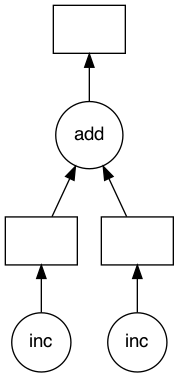

In [4]:
z.visualize()

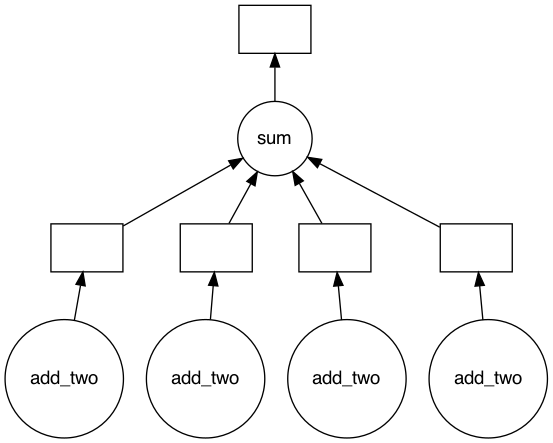

In [9]:
# add_two 함수 실행하기 
def add_two(x):
    return x + 2

def sum_two_numbers(x, y):
    return x + y

def multiply_four(x) :
    return x * 4

data = [1, 5, 8, 10]

step1 = [delayed(add_two)(i) for i in data]
total = delayed(sum)(step1)
total.visualize()

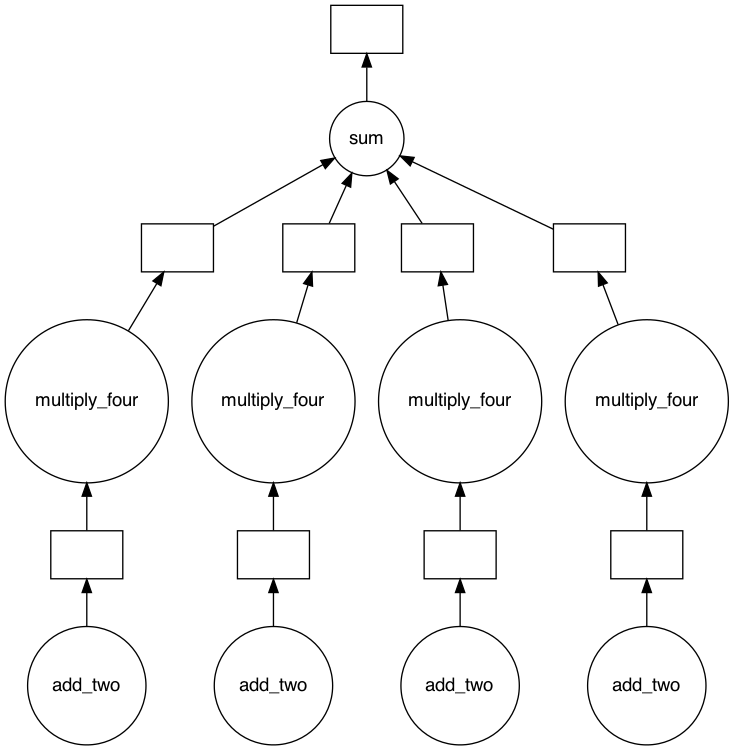

In [13]:
step1 = [delayed(add_two)(i) for i in data]
step2 = [delayed(multiply_four)(j) for j in step1]
total = delayed(sum)(step2)
total.visualize()

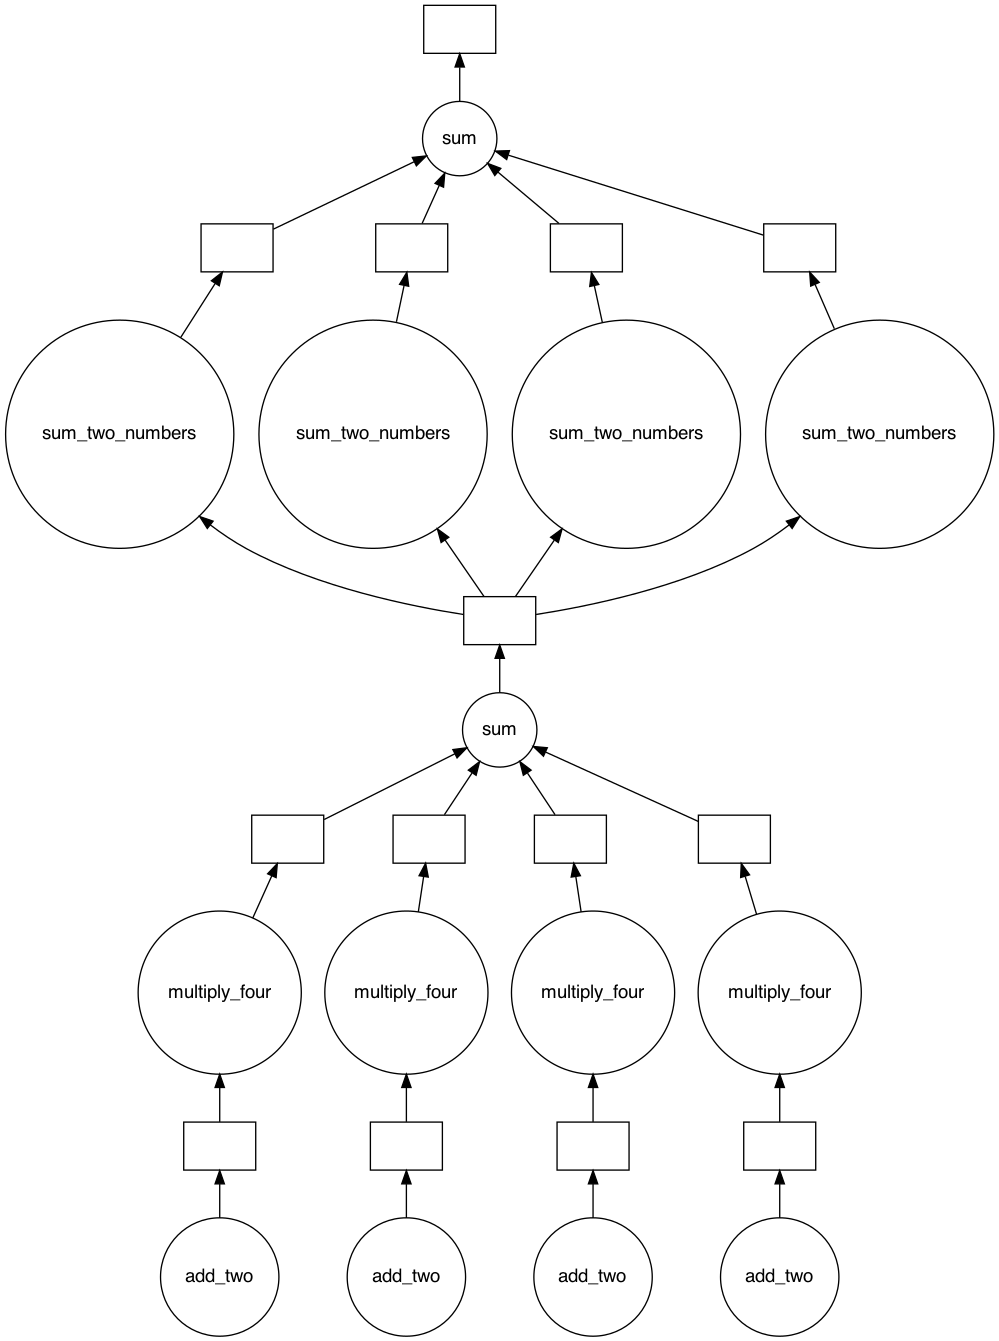

In [16]:
# persist 메서드를 사용하여 DAG의 복잡도 줄이기 
# DAG에 다른 계층 추가하기 

data2 = [delayed(sum_two_numbers)(k, total) for k in data]
total2 = delayed(sum)(data2)
total2.visualize()

- 큰 분산 데이터 집합이었다면 훨씬 복잡한 DAG가 생성됨
- persist를 사용하여 중간 결과를 유지한다면 성능 향상에 도움이 됨

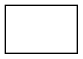

In [17]:
# 연산 지속하기
total_persisted = total.persist() # persist를 통해 DAG가 아닌 단일 결과를 얻어냄 
total_persisted.visualize()

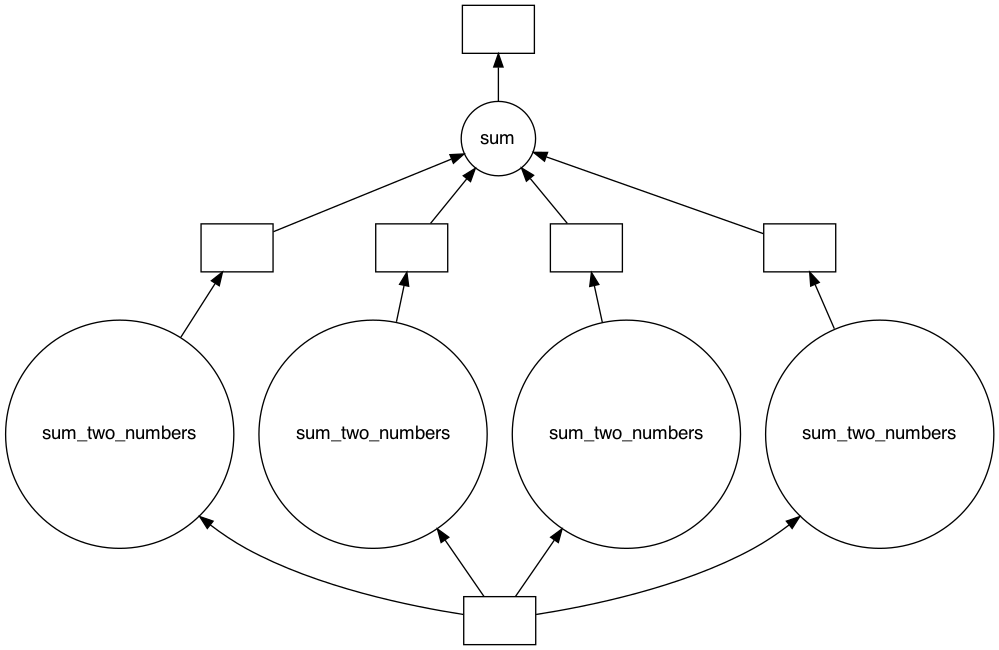

In [19]:
# 유지한 DAG에 또 다른 DAG 연결
data2 = [delayed(sum_two_numbers)(l, total_persisted) for l in data]
total2 = delayed(sum)(data2)
total2.visualize()

In [21]:
missing_count.visualize()

NameError: name 'missing_count' is not defined